# Global-scale atmospheric moisture and mass budgets on ERA5 pressure level data

In [1]:
import os
import sys
import xarray as xr
import numpy as np

In [2]:
sys.path.insert(0, os.path.realpath('../libs/'))
from physics_utils import grid_area, pressure_integral, weighted_sum

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Earth's radius
RAD_EARTH = 6371000 # m
RVGAS = 461.5 # J/kg/K
RDGAS = 287.05 # J/kg/K
GRAVITY = 9.80665 # m/s^2
RHO_WATER = 1000.0 # kg/m^3
LH_WATER = 2.501e6  # J/kg
LH_ICE = 333700 # J/kg
CP_DRY = 1004.64 # J/kg K
CP_VAPOR = 1810.0 # J/kg K
CP_LIQUID = 4188.0 # J/kg K
CP_ICE = 2117.27 # J/kg K

N_seconds = 3600 * 6  # 6-hourly data

# Function to compute mass residual
def dry_air_mass_residual(q, level_p, area):
    '''
    Compute the mass residual over time.

    Args:
        q: xarray.DataArray of specific total water (time, level, latitude, longitude)
        level_p: xarray.DataArray of pressure levels in Pa
        area: xarray.DataArray of grid cell areas (latitude, longitude)

    Returns:
        mass_dry_res: xarray.DataArray of mass residuals over time
    '''
    # Compute mass of dry air per unit area
    mass_dry_per_area = pressure_integral(1 - q, level_p) / GRAVITY  # Units: kg/m^2

    # Compute global mass of dry air by summing over latitude and longitude
    mass_dry_sum = weighted_sum(mass_dry_per_area, area, dims=('latitude', 'longitude'))  # Units: kg

    # Compute time difference of global dry air mass
    mass_dry_res = mass_dry_sum.diff('time')  # Units: kg

    return mass_dry_sum, mass_dry_res

# Function to compute water budget residuals
def water_budget_residual(q, precip, evapor, N_seconds, area, level_p):
    '''
    Compute water budget residuals using xarray DataArrays.

    Args:
        q: xarray.DataArray of specific total water (time, level, latitude, longitude)
        precip: xarray.DataArray of total precipitation (time, latitude, longitude), units m
        evapor: xarray.DataArray of evaporation (time, latitude, longitude), units m
        N_seconds: Number of seconds between time steps
        area: xarray.DataArray of grid cell areas (latitude, longitude), units m^2
        level_p: xarray.DataArray of pressure levels, units Pa

    Returns:
        residual: xarray.DataArray of water budget residuals over time
    '''
    # Convert increments to fluxes (kg/m^2/s)
    precip_flux = precip.isel(time=slice(1, None)) * RHO_WATER / N_seconds  # kg/m^2/s
    evapor_flux = evapor.isel(time=slice(1, None)) * RHO_WATER / N_seconds  # kg/m^2/s

    # Compute Total Water Content (TWC) at each time step
    TWC = pressure_integral(q, level_p) / GRAVITY  # kg/m^2

    # Compute time derivative of TWC (difference over time)
    dTWC_dt = TWC.diff('time') / N_seconds  # kg/m^2/s
    
    # Compute weighted sums over area
    dTWC_sum = weighted_sum(dTWC_dt, area, dims=('latitude', 'longitude'))  # kg/s
    E_sum = weighted_sum(evapor_flux, area, dims=('latitude', 'longitude'))  # kg/s
    P_sum = weighted_sum(precip_flux, area, dims=('latitude', 'longitude'))  # kg/s

    TWC_sum = weighted_sum(TWC, area, dims=('latitude', 'longitude'))
    
    # Compute residual
    residual = -dTWC_sum - E_sum - P_sum

    return -dTWC_sum, residual

def energy_budget_residual(u, v, T, q_v, q_liquid, q_ice, 
                           GPH_surf, TOA_net, OLR, R_short, R_long, LH, SH, 
                           N_seconds, area, level_p):
    
    C_p = (1 - q_v - q_liquid - q_ice) * CP_DRY + q_v * CP_VAPOR + q_liquid * CP_LIQUID + q_ice * CP_ICE
    
    ken = 0.5 * (u ** 2 + v ** 2)
    
    E_qgk = (LH_WATER+LH_ICE) * q_v + LH_ICE*(q_liquid) + GPH_surf + ken
    
    
    R_T = (TOA_net + OLR) / N_seconds
    R_T = R_T.isel(time=slice(1, None))
    R_T_sum = weighted_sum(R_T, area, dims=('latitude', 'longitude'))
    
    F_S = (R_short + R_long + LH + SH) / N_seconds
    F_S = F_S.isel(time=slice(1, None))
    F_S_sum = weighted_sum(F_S, area, dims=('latitude', 'longitude'))
    
    # layer-wise atmospheric energy (sensible heat + others)
    E_level = C_p * T + E_qgk
    
    # total atmospheric energy (TE) of an air column
    TE = pressure_integral(E_level, level_p) / GRAVITY
    
    # ---------------------------------------------------------------------------- #
    # tendency of TE
    dTE_dt = TE.diff(dim='time') / N_seconds
    # global sum of TE tendency
    dTE_sum = weighted_sum(dTE_dt, area, dims=('latitude', 'longitude'))
    # compute the residual
    residual = (R_T_sum - F_S_sum) - dTE_sum
    return dTE_sum, residual
    

In [10]:
# Time indices for subsetting
ind_start = 1002
ind_end = 1010

In [11]:
# Load datasets
base_dir = '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/'

# Static dataset
filename_static = base_dir + 'static/ERA5_plevel_1deg_6h_conserve_static.zarr'
ds_static = xr.open_zarr(filename_static)

# Years to process
years = np.arange(1979, 2021, 1)

# Initialize empty lists to store data
q = []
q_v = []
q_liquid = []
q_ice = []
T = []
u = []
v = []
precip = []
evapor = []
TOA_net = []
OLR = []
R_short = []
R_long = []
LH = []
SH = []


GPH_surf = ds_static['geopotential_at_surface']

# ============================================================= #
# Calculate the total number of time steps across all years
total_time_steps = 0


time_steps_per_year = []

for i_year, year in enumerate(years):
    filename_ERA5 = base_dir + f'all_in_one/ERA5_plevel_1deg_6h_{year}_conserve.zarr'
    ds_ERA5 = xr.open_zarr(filename_ERA5)
    n_time = ds_ERA5.dims['time']
    total_time_steps += n_time
    time_steps_per_year.append(n_time)
    # --------------------------------------- #
    if i_year == 0:
        level_p = ds_ERA5['level'] * 100.0
        x = ds_ERA5['longitude']
        y = ds_ERA5['latitude']
        lon, lat = np.meshgrid(x, y)
        # Compute grid cell areas
        area = grid_area(lat, lon)
        
    ds_ERA5.close()

# Adjust ind_end if it exceeds total_time_steps
if ind_end > total_time_steps:
    ind_end = total_time_steps
    
# ============================================================= #
# Initialize cumulative time index
cumulative_time = 0

for i_year, year in enumerate(years):
    filename_ERA5 = base_dir + f'all_in_one/ERA5_plevel_1deg_6h_{year}_conserve.zarr'
    ds_ERA5 = xr.open_zarr(filename_ERA5)

    filename_cloud = base_dir + f'cloud/ERA5_plevel_1deg_6h_cloud_{year}_conserve.zarr'
    ds_cloud = xr.open_zarr(filename_cloud)
    
    # Get the number of time steps in the current year's dataset
    n_time = ds_ERA5.dims['time']

    # Determine if the current year's data overlaps with the desired indices
    year_ind_start = max(0, ind_start - cumulative_time)
    year_ind_end = min(n_time, ind_end - cumulative_time)

    # Check if there is an overlap
    if year_ind_start < year_ind_end:
        # Subset the data for the overlapping time indices
        time_slice = slice(year_ind_start, year_ind_end)
        
        # --------------------- #
        # q components
        q_v.append(ds_ERA5['Q'].isel(time=time_slice))
        q_v_da = ds_ERA5['Q'].isel(time=time_slice)
        q_cl = ds_cloud['CLWC'].isel(time=time_slice)
        q_ci = ds_cloud['CIWC'].isel(time=time_slice)
        q_r = ds_cloud['CRWC'].isel(time=time_slice)
        q_s = ds_cloud['CSWC'].isel(time=time_slice)
        q.append(q_v_da + q_cl + q_ci + q_r + q_s)
        q_liquid.append(q_cl + q_r)
        q_ice.append(q_ci + q_s)
        
        # --------------------- #
        # Subset and append other variables
        T.append(ds_ERA5['T'].isel(time=time_slice))
        u.append(ds_ERA5['U'].isel(time=time_slice))
        v.append(ds_ERA5['V'].isel(time=time_slice))
        precip.append(ds_ERA5['total_precipitation'].isel(time=time_slice))
        evapor.append(ds_ERA5['evaporation'].isel(time=time_slice))
        TOA_net.append(ds_ERA5['top_net_solar_radiation'].isel(time=time_slice))
        OLR.append(ds_ERA5['top_net_thermal_radiation'].isel(time=time_slice))
        R_short.append(ds_ERA5['surface_net_solar_radiation'].isel(time=time_slice))
        R_long.append(ds_ERA5['surface_net_thermal_radiation'].isel(time=time_slice))
        LH.append(ds_ERA5['surface_latent_heat_flux'].isel(time=time_slice))
        SH.append(ds_ERA5['surface_sensible_heat_flux'].isel(time=time_slice))

    # Update cumulative time index
    cumulative_time += n_time

# After processing all years, concatenate the lists along the 'time' dimension
q = xr.concat(q, dim='time')
q_v = xr.concat(q_v, dim='time')
q_liquid = xr.concat(q_liquid, dim='time')
q_ice = xr.concat(q_ice, dim='time')
T = xr.concat(T, dim='time')
u = xr.concat(u, dim='time')
v = xr.concat(v, dim='time')
precip = xr.concat(precip, dim='time')
evapor = xr.concat(evapor, dim='time')
TOA_net = xr.concat(TOA_net, dim='time')
OLR = xr.concat(OLR, dim='time')
R_short = xr.concat(R_short, dim='time')
R_long = xr.concat(R_long, dim='time')
LH = xr.concat(LH, dim='time')
SH = xr.concat(SH, dim='time')

mass_value, mass_residual = dry_air_mass_residual(q, level_p, area)
water_tendency, water_residual = water_budget_residual(q, precip, evapor, N_seconds, area, level_p)
energy_tendency, energy_residual = energy_budget_residual(u, v, T, q_v, q_liquid, q_ice, 
                                                          GPH_surf, TOA_net, OLR, R_short, R_long, LH, SH, 
                                                          N_seconds, area, level_p)

ds_mass = xr.Dataset({
    'global_mass_value': mass_value,
    'global_mass_residual': mass_residual,
})

ds_water = xr.Dataset({
    'global_water_tendency': water_tendency,
    'global_water_residual': water_residual,
})

ds_energy = xr.Dataset({
    'global_energy_tendency': energy_tendency,
    'global_energy_residual': energy_residual,
})

save_name_mass = '/glade/derecho/scratch/ksha/CREDIT/VERIF/verif_6h/ERA5_clim/ERA5_mass_residual_1deg_full_{:05d}_{:05d}.nc'
save_name_water = '/glade/derecho/scratch/ksha/CREDIT/VERIF/verif_6h/ERA5_clim/ERA5_water_residual_1deg_full_{:05d}_{:05d}.nc'
save_name_energy = '/glade/derecho/scratch/ksha/CREDIT/VERIF/verif_6h/ERA5_clim/ERA5_energy_residual_1deg_full_{:05d}_{:05d}.nc'

# ds_mass.to_netcdf(save_name_mass.format(ind_start, ind_end), compute=True)
# ds_water.to_netcdf(save_name_water.format(ind_start, ind_end), compute=True)
# ds_energy.to_netcdf(save_name_energy.format(ind_start, ind_end), compute=True)

In [18]:
mass_residual_np = mass_residual.values
water_residual_np = water_residual.values
energy_residual_np = energy_residual.values

print(mass_residual_np)
print(water_residual_np)
print(energy_residual_np)

[-1.70198076e+13 -1.56004675e+12 -1.32437839e+13 -1.00585541e+13
 -6.96143325e+12  2.29661326e+13 -1.07637119e+13]
[-1.33120319e+09 -1.15590584e+09 -2.91183274e+08 -1.26527119e+08
 -1.22135899e+09 -3.15887567e+08 -1.30222869e+08]
[-1.32732133e+15 -2.40820718e+15 -2.34140401e+15 -1.46194951e+16
  1.53046869e+14  8.75385705e+14 -6.96686973e+14]


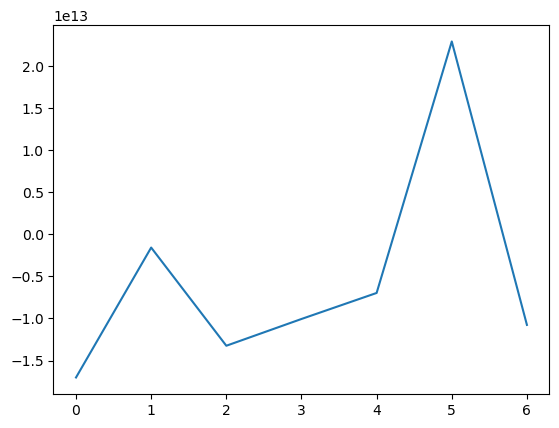

In [16]:
plt.plot(mass_residual_np)

In [17]:
mass_residual_np

array([-1.70198076e+13, -1.56004675e+12, -1.32437839e+13, -1.00585541e+13,
       -6.96143325e+12,  2.29661326e+13, -1.07637119e+13])